# **SIN 393 – Introduction to Computer Vision (2024)**

# Lecture 06 - Part 2 - Convolutional Neural Networks

Prof. João Fernando Mari ([*joaofmari.github.io*](https://joaofmari.github.io/))

---
* Fine-tuning pre-trained models
* Training and validating during the training loop
* Detailed evaluation report

## Mounting Google Drive
---

* If you are running on Google Colab, don't forget to enable GPU access.
    * Edit >> Laptop Settings >> Hardware Accelerator
    * Select GPU
    * OK
* After use, disable access.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# DEBUG
print(IN_COLAB)

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

False


## Importing the required libraries
---


In [2]:
import os
import random
import time
import platform

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
import torch.nn.functional as F
from torch import nn, optim
# import torch.nn as nn 
# import torch.optim as optim 
from torch.optim import lr_scheduler 

from torchvision import transforms, models, datasets, utils

## Settings for reproducibility
---
* Convolutional Neural Network (CNN) operations often rely on random numbers.
* When repeating an experiment multiple times, the results may exhibit slight variations, even when using the same data, models, and hyperparameters.
* To ensure reproducibility across different experiment runs, it is often beneficial to set fixed seeds for the random number generators.

In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Checking GPU Access
---

In [4]:
# Check if the GPU is available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\nDevice: {0}'.format(DEVICE))


Device: cuda


In [5]:
!nvidia-smi

Tue Nov 19 20:42:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti     Off | 00000000:01:00.0 Off |                  N/A |
| 49%   37C    P0              N/A /  75W |    158MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## The dataset
---
* Flower dataset
    * https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
    * 4242 imagens de flores
    * 5 classes
 * Folder hierarch:
    * [flowers]
        * [daisy]
        * [dandelion]
        * [rose]
        * [suinflower]
        * [tulip]

In [6]:
if IN_COLAB:
    ds_path = '/content/drive/My Drive/Data/flowers-recognition/flowers/'
else:
    ### ds_path = 'data/flowers-recognition/flowers/'
    ds_path = '/home/joao/Datasets/flowers-recognition/flowers/'

In [7]:
# # Class names
# class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

# # Number of  classes
# num_classes = len(class_names)

## Setting some hyperparameters
---

In [8]:
# Batch size (mini-batch size)
batch_size = 64
# Learning rate
lr = 0.0001
# Mommentum
mm = 0.9
# Number of training epochs
epochs = 10 # Use a small value during development, 2 for example.

## Preparing the dataset
---

In [9]:
# Data transforms
data_transforms = transforms.Compose([# It is necessary to resize the images to match the network's input size.
                                      # The images in the Flowers dataset have varying dimensions.
                                      transforms.Resize(size=(224, 224)),
                                      transforms.ToTensor(),
                                      # Mean and standard deviation of ImageNet.
                                      # These are required as we will use a model pre-trained on ImageNet.
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
                                     ])

# Builds a dataset from a directory.
# The directory must contain a subdirectory for each class in the problem.
full_dataset = datasets.ImageFolder(ds_path, transform=data_transforms)

# Class names
class_names = full_dataset.classes
print("Class names:", class_names)

# Number of  classes
num_classes = len(class_names)

Class names: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


### Visualizing some images

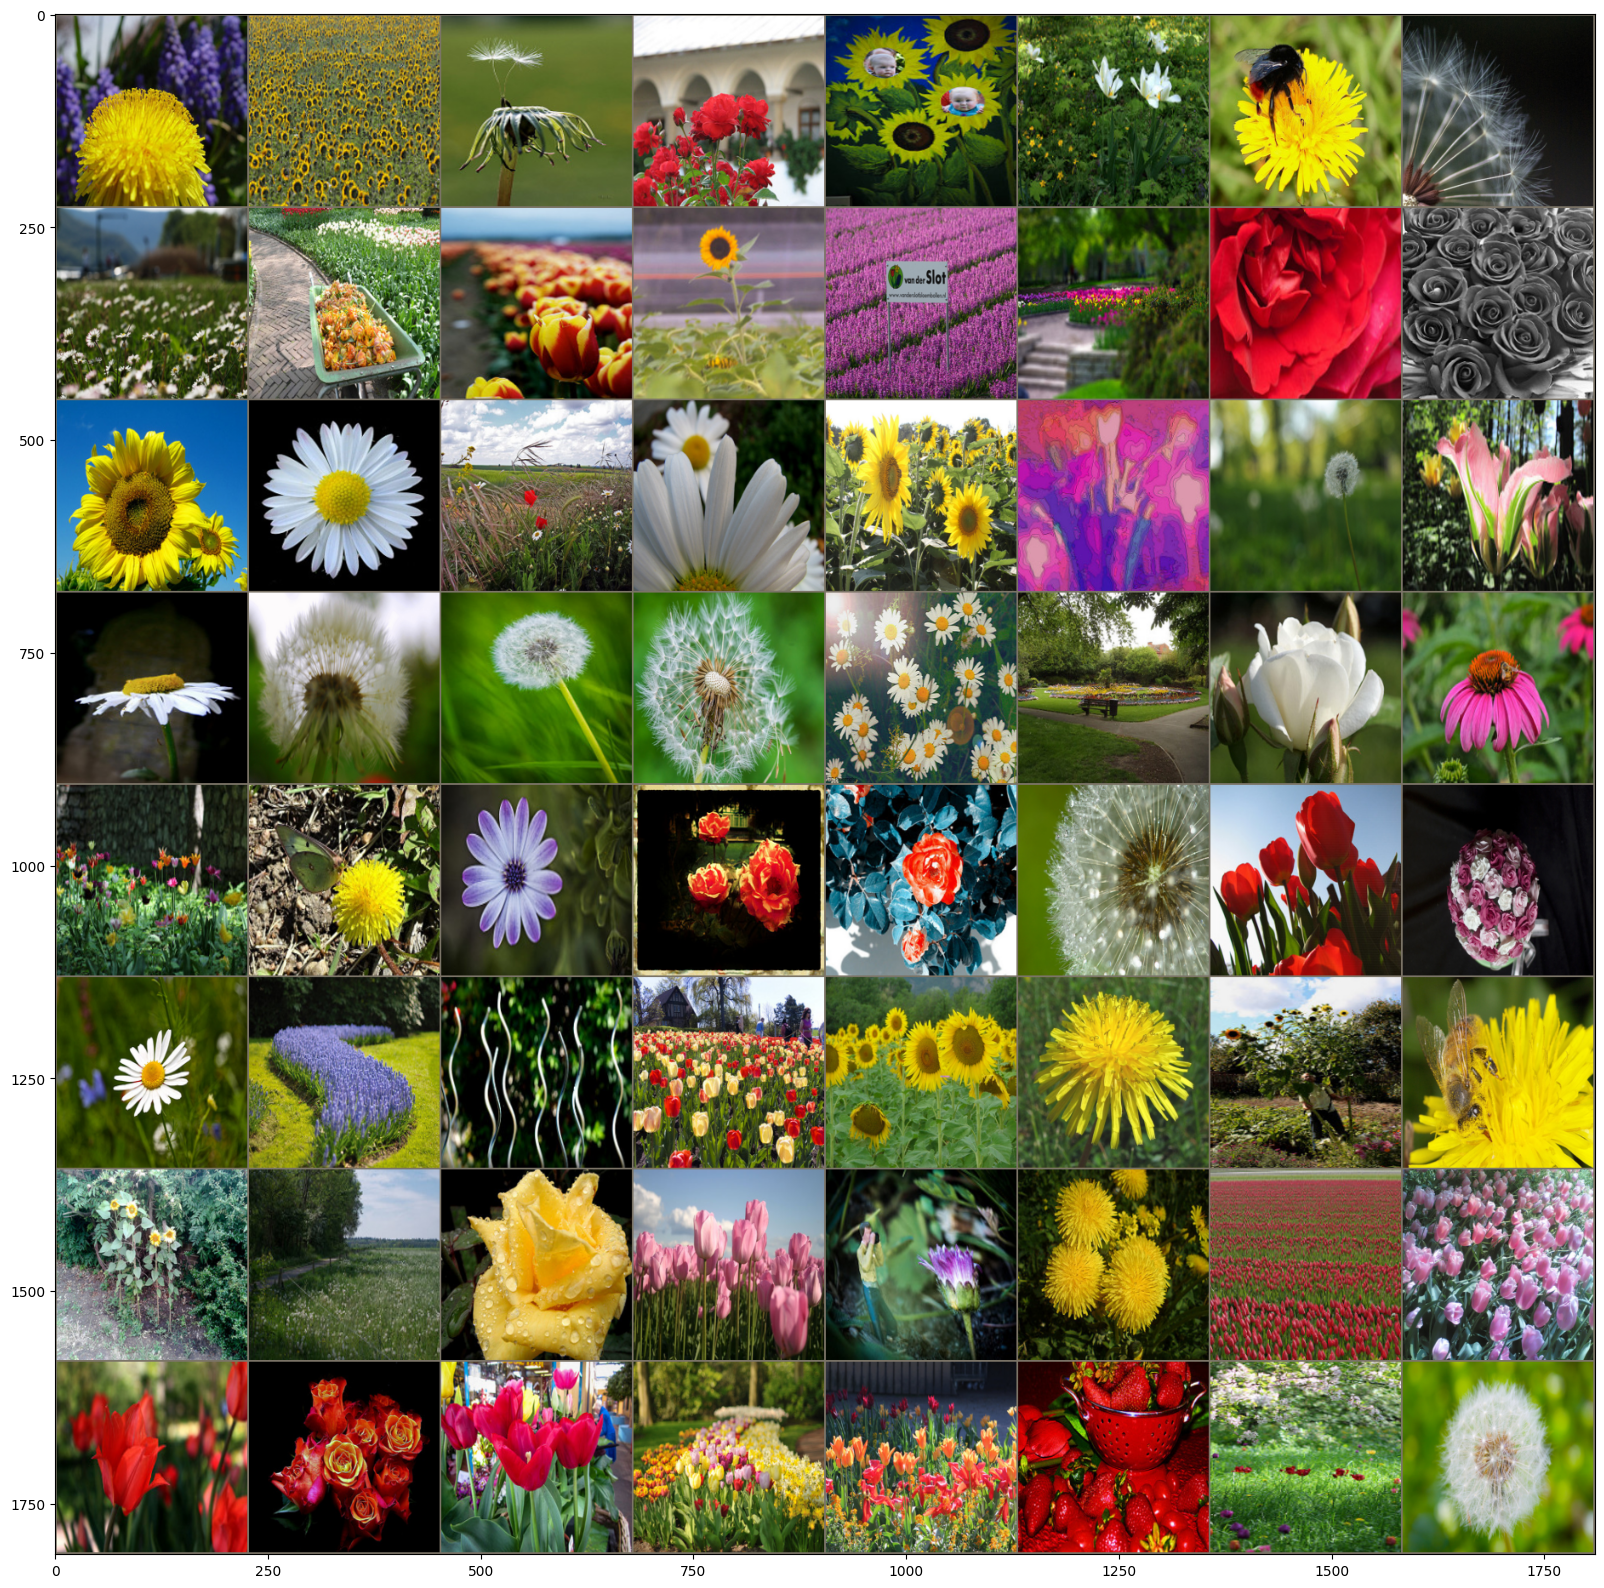

In [10]:
def show_transformed_image(image):
    # Unnormalize the channels. ImageNet weights
    for t, m, s in zip(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):        
        t.mul_(s).add_(m)

    np_image = image.numpy()

    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

# Visualize 'batch_size' images
dataloader_vis = torch.utils.data.DataLoader(dataset=full_dataset, shuffle=True, batch_size=64)
items = iter(dataloader_vis)
### image, label = items.next()
image, label = next(items)

show_transformed_image(utils.make_grid(image))

## Spliting the dataset in training and test sets
---


In [11]:
# Training set: 80 %
train_size = int(0.8 * len(full_dataset))
# Validation set: 20 %
test_size = len(full_dataset) - train_size

# Spliting the full dataset
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# Number of images in each split
train_size = len(train_dataset)
val_size = len(val_dataset)

print(train_size)
print(val_size)

# Defining the dataloaders
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size)

3453
864


In [12]:
class Net(nn.Module):
    """
    Considering each image having 224 x 224 x 3:
    
    Input [3, 224, 224] 
    Conv1(3, 6, 5) [6, 220, 220] 
    Pool(2, 2) 16, 110, 110]
    Conv2(6, 16, 5) [16, 106, 106]
    Pool(2, 2) [16, 53, 53]
    Flatten [44944] (16 x 53 x 53 = 44944)
    Fc1 [120]
    Fc2 [84]
    Fc3 [10]
    """
    def __init__(self, in_channels, num_classes):
        """
        torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
                        dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
        """
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        # conv1(x): Input: [224, 224, 3]. Output: [220, 220, 6].
        x = self.conv1(x)
        x = F.relu(x)
        # pool: Input: [220, 220, 6], Output: [110, 110, 6]
        x = self.pool(x)
        # conv2: Input: [110, 110, 6]. Output: [106, 106, 16].
        x = self.conv2(x)
        x = F.relu(x)
        # pool: Input: [106, 106, 16], Output: [53, 53, 16]
        x = self.pool(x)
        # flatten: Input: [53, 53, 16]. Output: [44944]
        x = torch.flatten(x, 1) 
        # fc1: Input: [44944]. Output: [120]
        x = self.fc1(x)
        x = F.relu(x)
        # fc2: Input: [120]. Output: [84]
        x = self.fc2(x)
        x = F.relu(x)
        # fc3: Input: [80]. Output: [num_classes]
        x = self.fc3(x)
        
        return x

## Using a pretrainned model (fine-tunning)
---


In [13]:
# Fine-tuning
model_ft = models.alexnet(weights='AlexNet_Weights.DEFAULT')
# From Scratch
### model_ft = models.alexnet(weights=None)

# Changes the number of neurons in the output layer.
model_ft.classifier[6] = nn.Linear(4096, num_classes)

## Selecting the model
---

In [14]:
# Simple net
### model = Net(3, 5)

# Pretrainned model
model = model_ft

In [15]:
# Send the model to the GPU
if DEVICE.type == 'cuda':
    model = model.cuda() # Cuda
    
# Print the model
print(str(model))

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Loss function and optimizer

In [16]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mm)

## Training the model
---

In [17]:
# Total training time (including training and validation).
time_total_start = time.time()

# List of training losses and accuracies for each epoch.
train_loss_list = []
train_acc_list = []

# List of validation losses and accuracies for each epoch.
val_loss_list = []
val_acc_list = []

for epoch in range(epochs):
    # TRAINING
    # =========================================================================
    # Starts timing the epoch.
    time_epoch_start = time.time()

    # Enables the model for training mode
    model.train() 

    # Loss for this epoch.
    loss_epoch_train = 0.0    
    # Samples correctly classified in this epoch.
    hits_epoch_train = 0  

    # Iterate along the batches of the TRAINING SET
    for inputs, labels in train_dataloader:
        # Send data to GPU
        inputs = inputs.to(DEVICE) 
        labels = labels.to(DEVICE) 

        # Zero the parameter gradients
        optimizer.zero_grad() 

        # Enable gradient calculation during training.
        torch.set_grad_enabled(True) 

        # -----> FORWARD
        # Model output
        outputs = model(inputs) 

        # 'outputs' contains float values. Take the maximum values as the predictions.
        preds = torch.argmax(outputs, dim=1).float() 

        # Compute the loss function
        loss = criterion(outputs, labels)

        # BACKWARD
        # <-------
        loss.backward() 

        # Optimizes the parameters (weights)
        optimizer.step()

        # Updates the epoch loss
        loss_epoch_train += float(loss.item()) * inputs.size(0) 

        # Updates the epoch hits
        hits_epoch_train += torch.sum(preds == labels.data) 

    # Training loss and accuracy for this epoch.
    train_loss = loss_epoch_train / train_size
    train_acc = float(hits_epoch_train.double() / train_size)

    # Store loss and accuracy in lists
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # VALIDATION
    # =========================================================================
    model.eval() 

    # Epoch validation loss
    loss_epoch_val = 0.0 
    # Num hits for this epoch
    hits_epoch_val = 0 
    
    # Iterate along the batches of the VALIDATION SET
    for inputs, labels in val_dataloader:

        # Send data to GPU
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Zero the parameter gradients
        optimizer.zero_grad() 

        # Disables gradient calculation during validation.
        torch.set_grad_enabled(False) 

        # -----> FORWARD
        # Model output
        outputs = model(inputs) 

        # Returns the largest prediction.
        preds = torch.argmax(outputs, dim=1).float()

        # Compute the loss
        loss = criterion(outputs, labels) 

        # Updates the epoch loss
        loss_epoch_val += float(loss.item()) * inputs.size(0)
        # Updates the epoch hits
        hits_epoch_val += torch.sum(preds == labels.data)

    # Adjust the learning rate
    ### scheduler.step() 
        
    # Validation loss and accuracy for this epoch.
    val_loss = loss_epoch_val / val_size
    val_acc = float(hits_epoch_val.double() / val_size)

    # Store val loss and accuracy in lists
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    # Total time for this epoch
    time_epoch = time.time() - time_epoch_start
    
    # PRINTING
    # --------
    print(f'Epoch {epoch}/{ epochs - 1} - TRAIN Loss: {train_loss:.4f} TRAIN Acc: {train_acc:.4f} - VAL. Loss: {val_loss:.4f} VAL. Acc: {val_acc:.4f} ({time_epoch:.4f} seconds)')

# Total training time
time_total_train = time.time() - time_total_start

# PRINTING
print(f'\nTraining finished! ({int(time_total_train // 60)}m and {int(time_total_train % 60)}s)')

Epoch 0/9 - TRAIN Loss: 1.0138 TRAIN Acc: 0.6027 - VAL. Loss: 0.5663 VAL. Acc: 0.7975 (24.9505 seconds)
Epoch 1/9 - TRAIN Loss: 0.5408 TRAIN Acc: 0.7973 - VAL. Loss: 0.4523 VAL. Acc: 0.8275 (24.5131 seconds)
Epoch 2/9 - TRAIN Loss: 0.4715 TRAIN Acc: 0.8265 - VAL. Loss: 0.4077 VAL. Acc: 0.8380 (24.5312 seconds)
Epoch 3/9 - TRAIN Loss: 0.4154 TRAIN Acc: 0.8558 - VAL. Loss: 0.3791 VAL. Acc: 0.8565 (24.4841 seconds)
Epoch 4/9 - TRAIN Loss: 0.3834 TRAIN Acc: 0.8662 - VAL. Loss: 0.3625 VAL. Acc: 0.8646 (24.5646 seconds)
Epoch 5/9 - TRAIN Loss: 0.3612 TRAIN Acc: 0.8720 - VAL. Loss: 0.3497 VAL. Acc: 0.8692 (24.5712 seconds)
Epoch 6/9 - TRAIN Loss: 0.3306 TRAIN Acc: 0.8865 - VAL. Loss: 0.3365 VAL. Acc: 0.8750 (24.4956 seconds)
Epoch 7/9 - TRAIN Loss: 0.3146 TRAIN Acc: 0.8865 - VAL. Loss: 0.3254 VAL. Acc: 0.8773 (24.5563 seconds)
Epoch 8/9 - TRAIN Loss: 0.3010 TRAIN Acc: 0.8989 - VAL. Loss: 0.3177 VAL. Acc: 0.8843 (24.7135 seconds)
Epoch 9/9 - TRAIN Loss: 0.2931 TRAIN Acc: 0.8955 - VAL. Loss: 0.

## Analyzing the training
---

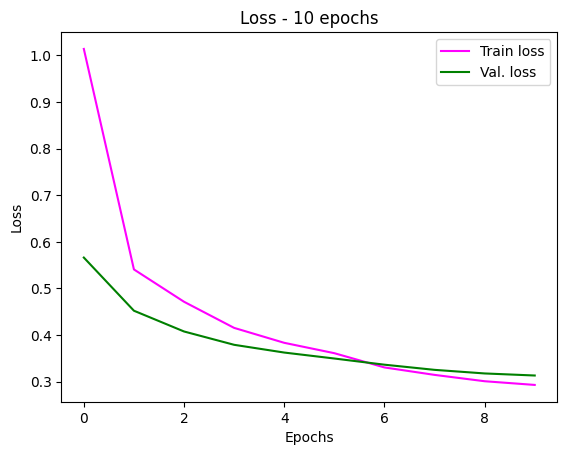

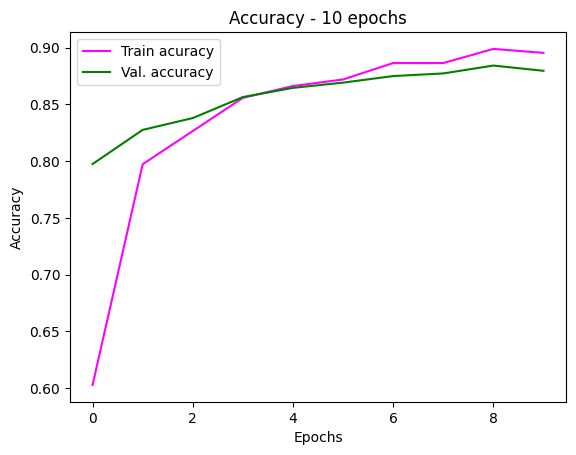

In [18]:
# List with epoch indexes. [0, 1, ... num_epochs - 1]
epochs_list = list(range(len(train_loss_list)))

# Plot - Loss 
plt.figure()
plt.title(f'Loss - {epochs} epochs')
plt.plot(epochs_list, train_loss_list, c='magenta', ls='-', label='Train loss', fillstyle='none')
plt.plot(epochs_list, val_loss_list, c='green', ls='-', label='Val. loss', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

# Plot - Accuracy
plt.figure()
plt.title(f'Accuracy - {epochs} epochs')
plt.plot(epochs_list, train_acc_list, c='magenta' ,ls='-', label='Train acuracy', fillstyle='none')
plt.plot(epochs_list, val_acc_list, c='green' ,ls='-', label='Val. accuracy', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

## Evaluating the model over the test set
---

In [19]:
# List with true and predicted classes
true_val_list = []
pred_val_list = []
# List with probabilities
prob_val_list = []

# Iterate along the batches of the VALIDATION SET
for i, (img_list, label_list) in enumerate(val_dataloader):
    # Send data to GPU
    img_list = img_list.to(DEVICE)
    labelList = label_list.to(DEVICE)

    # Disables gradient calculation during validation and testing.
    torch.set_grad_enabled(False) 

    # -----> FORWARD
    # Model output
    outputs = model(img_list)

    # Prediction
    preds = torch.argmax(outputs, dim=1)

    # Computes probabilities of each class
    # https://discuss.pytorch.org/t/obtain-probabilities-from-cross-entropy-loss/157259
    outputs_prob = nn.functional.softmax(outputs, dim=1)

    # True classes and predicted classes for this batch.
    if DEVICE.type == 'cuda':
        true_val_batch = list(label_list.cpu())
        pred_val_batch = list(preds.cpu())
        prob_val_batch = list(outputs_prob.cpu())
    else:
        true_val_batch = list(label_list)
        pred_val_batch = list(preds)
        prob_val_batch = list(outputs_prob)
        
    # Append batch results to the lists
    true_val_list += true_val_batch
    pred_val_list += pred_val_batch
    
    prob_val_list += prob_val_batch

## Confusion matrix and classification report
---

In [20]:
# Confusion matrix
conf_mat_val = metrics.confusion_matrix(true_val_list, pred_val_list)
print('\nConfusion matrix ( validation)')
print(conf_mat_val)

# Classification report - Scikit-learn
class_rep_val = metrics.classification_report(true_val_list, pred_val_list, 
                                              target_names=class_names, digits=4,
                                              zero_division=0)
print('\nClass. report (validation)')
print(class_rep_val)

# Accuracy
acc_val = metrics.accuracy_score(true_val_list, pred_val_list)
print('\n\nValidation Acc.: {:.4f}'.format(acc_val))


Confusion matrix ( validation)
[[138   8   1   3   4]
 [  6 201   2   8   3]
 [  4   0 129   1  19]
 [  5   7   1 128   8]
 [  4   2  14   4 164]]

Class. report (validation)
              precision    recall  f1-score   support

       daisy     0.8790    0.8961    0.8875       154
   dandelion     0.9220    0.9136    0.9178       220
        rose     0.8776    0.8431    0.8600       153
   sunflower     0.8889    0.8591    0.8737       149
       tulip     0.8283    0.8723    0.8497       188

    accuracy                         0.8796       864
   macro avg     0.8791    0.8769    0.8777       864
weighted avg     0.8804    0.8796    0.8797       864



Validation Acc.: 0.8796


### Detailed classification report

In [21]:
# Test set
print('\n#\tTarget\tPrediction\tCorrect?', end='')

for class_name in class_names:
    print(f'\t {class_name}', end='')

for i, (true, pred, probs) in enumerate(zip(true_val_list, pred_val_list, prob_val_list)):
    print(f'\n{i} \t {true} \t {pred} \t {true==pred}', end='')

    for prob in probs:
        print(f'\t{prob:.4f}', end='')


#	Target	Prediction	Correct?	 daisy	 dandelion	 rose	 sunflower	 tulip
0 	 0 	 0 	 True	0.9568	0.0110	0.0003	0.0287	0.0032
1 	 3 	 3 	 True	0.0043	0.0003	0.0019	0.9928	0.0007
2 	 2 	 2 	 True	0.0002	0.0000	0.9181	0.0000	0.0817
3 	 3 	 3 	 True	0.0279	0.3398	0.0000	0.6323	0.0000
4 	 4 	 4 	 True	0.0009	0.0003	0.0084	0.0037	0.9867
5 	 1 	 1 	 True	0.3352	0.6089	0.0021	0.0517	0.0020
6 	 4 	 4 	 True	0.0000	0.0000	0.0016	0.0000	0.9983
7 	 1 	 1 	 True	0.0144	0.9781	0.0033	0.0026	0.0014
8 	 1 	 1 	 True	0.1362	0.3694	0.0029	0.2009	0.2905
9 	 4 	 3 	 False	0.2940	0.0125	0.1462	0.3516	0.1955
10 	 0 	 0 	 True	0.9999	0.0000	0.0000	0.0001	0.0000
11 	 4 	 4 	 True	0.0007	0.0001	0.0192	0.0001	0.9799
12 	 2 	 2 	 True	0.0071	0.0003	0.8088	0.0006	0.1831
13 	 2 	 2 	 True	0.0505	0.1691	0.5200	0.0627	0.1977
14 	 4 	 4 	 True	0.0008	0.0046	0.0180	0.0063	0.9703
15 	 0 	 0 	 True	0.8077	0.0928	0.0002	0.0987	0.0005
16 	 1 	 1 	 True	0.0043	0.9926	0.0017	0.0002	0.0013
17 	 0 	 0 	 True	0.9942	0.0028	0.00

## Bibliography
---
* PyTorch. Training a Classifier
    * https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* Microsoft. Train your image classifier model with PyTorch.
    * https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-train-model
* Nathan Inkawhich. FINETUNING TORCHVISION MODELS.
    * (Broken link) https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html 
    * (New link) https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/finetuning_torchvision_models_tutorial.ipynb#scrollTo=kfl9S6PnhsuC
* Sasank Chilamkurthy. TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL. 
    * https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

